In [1]:
%matplotlib inline
import sys
import errno
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
from collections import OrderedDict
from matplotlib import pyplot as plt
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")

Global variables that sets the range the volatility is calculated from, and the rigidness of the changepoints

In [2]:
_volatility_range = 6
_change_flex = 0.5

In [3]:
colors = ['b', 'r', 'g']

Pulls the data from the appropriate url and saves it as a data frame

In [4]:
import requests

POLONIEX_OHLCV_BASEURL = 'https://poloniex.com/public?command=returnChartData&currencyPair='

def get_ohlcv_poloniex(pair='BTC_ETH', start=1435699200, end=9999999999, period=14400):
    """
    returns ohlcv data for poloniex as pandas dataframe
    convert to unix timestamp using https://coderstoolbox.net/unixtimestamp/
    :param pair: str pair on poloniex
    :param start: int unix timestamp of beginning time
    :param end: int unix timestamp of ending time
    :param period: int candle width in seconds
    :return: pandas df of ohlcv data from poloniex for specified pair, times, and period
    """
    query = POLONIEX_OHLCV_BASEURL + pair + '&start=' + str(start) + '&end=' + str(end) + '&period=' + str(period)
    resp = requests.get(query)

    if resp.status_code != 200:
        raise requests.ApiError('GET /tasks/ {}'.format(resp.status_code))

    return pd.DataFrame(resp.json())

In [5]:
all_data = get_ohlcv_poloniex(pair='USDT_BTC', start=1483600958, end=9999999999, period=86400)
all_data['ds'] = pd.to_datetime(all_data['date'], unit='s')

Prints frame data

In [6]:
all_data.describe()

,close,date,high,low,open,quoteVolume,volume,weightedAverage
count,632.000000,6.320000e+02,632.000000,632.000000,632.000000,632.000000,6.320000e+02,632.000000
mean,5863.543081,1.510920e+09,6075.672832,5594.144835,5855.387096,6621.446945,3.320305e+07,5835.561683
std,3940.224517,1.577551e+07,4135.242933,3690.669811,3944.417587,7128.742414,4.189986e+07,3908.041901
min,781.811601,1.483661e+09,823.498000,751.000000,781.851601,326.710546,3.275330e+05,787.033432
25%,2384.066782,1.497290e+09,2474.365276,2235.000000,2375.617482,1449.384752,7.029746e+06,2353.582013
50%,6251.638001,1.510920e+09,6458.794880,6122.228937,6248.500000,4562.690043,1.910059e+07,6287.217296
75%,8165.145463,1.524550e+09,8329.105083,7842.625000,8168.996003,8895.894334,4.161335e+07,8108.910407
max,19223.000000,1.538179e+09,19903.440214,18569.637853,19223.000000,48896.616808,3.960385e+08,19236.130652


Selects the appropriate data from the full frame
Pulls the dates and prices from the data and creates the log and volatility columns

In [7]:
df = all_data[['ds','date','close']]
df.columns = ['ds','date','price']
df['log'] = np.log(df['price'])
df['vol'] = df['log'].rolling(_volatility_range).std()
df.dropna();

Shows statistics for the three columns

In [8]:
df.describe()

,date,price,log,vol
count,6.320000e+02,632.000000,632.000000,627.000000
mean,1.510920e+09,5863.543081,8.385034,0.045365
std,1.577551e+07,3940.224517,0.840258,0.026352
min,1.483661e+09,781.811601,6.661614,0.007521
25%,1.497290e+09,2384.066782,7.776561,0.025132
50%,1.510920e+09,6251.638001,8.740599,0.040285
75%,1.524550e+09,8165.145463,9.007630,0.059550
max,1.538179e+09,19223.000000,9.863863,0.170529


Displays kurtosis for the three data sources

Kurtosis for log and vol is relatively low indicating that there aren't many extrema.

In [9]:
df.kurtosis()

date    -1.200000
price    0.293579
log     -0.918600
vol      2.069402
dtype: float64

Displays skew for the three data sources

The skew is positive meaning that that the the graph is asymmetric with a left weight

In [10]:
df.skew()

date    -3.396929e-17
price    7.319889e-01
log     -5.338811e-01
vol      1.278427e+00
dtype: float64

Generates the prophet and forecasts the specified data stream

In [11]:
m = Prophet(changepoint_prior_scale = _change_flex);
df['y'] = df['vol']
m.fit(df)

In [12]:
plt.rcParams['figure.figsize'] = [11,6]

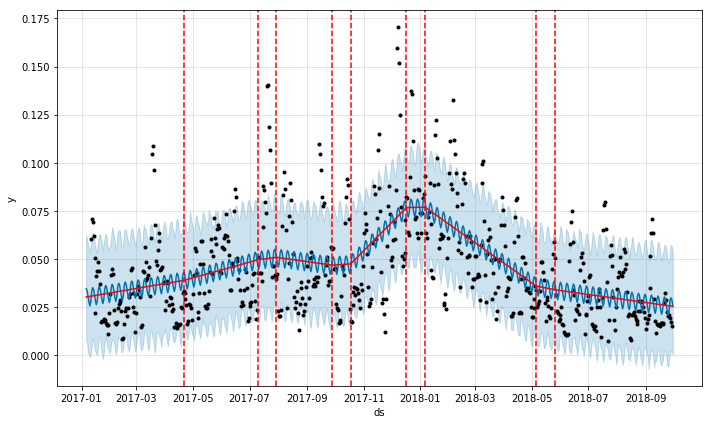

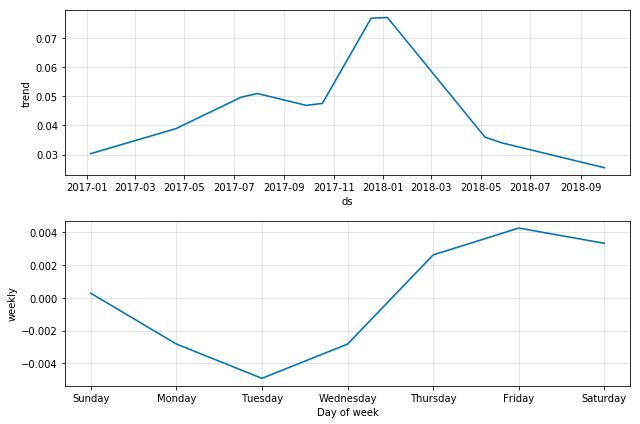

In [13]:
future = m.make_future_dataframe(periods=1)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

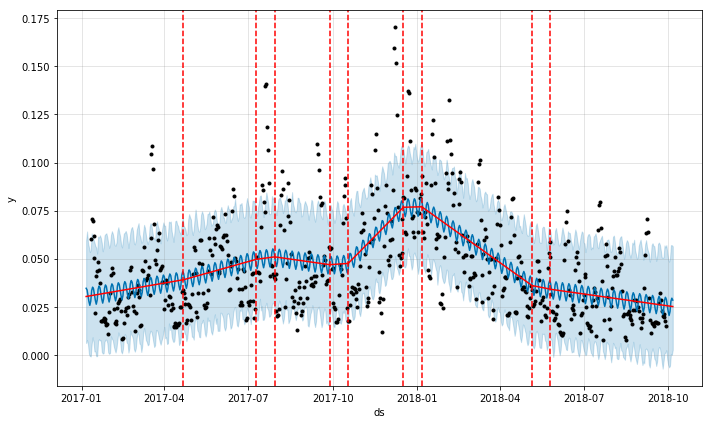

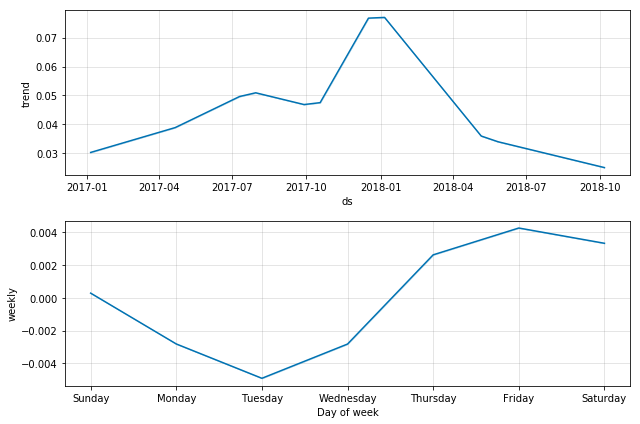

In [14]:
future = m.make_future_dataframe(periods=7)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

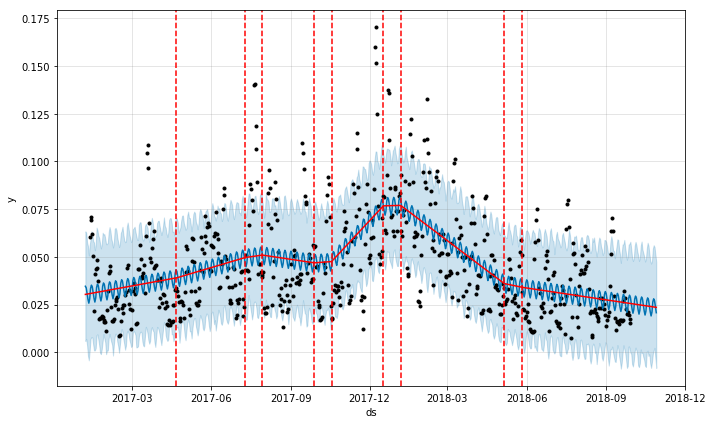

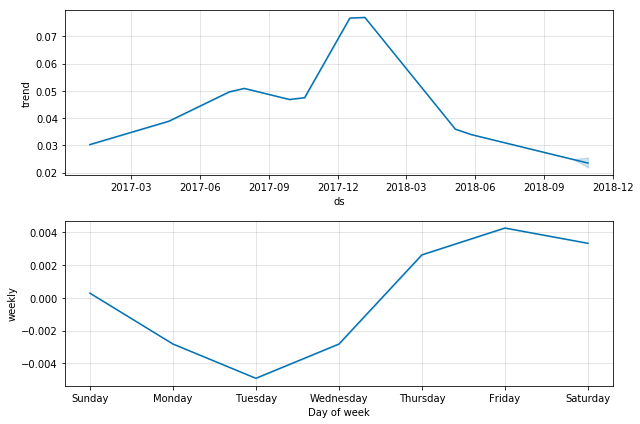

In [15]:
future = m.make_future_dataframe(periods=30)
future.tail()
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)
fig2 = m.plot_components(forecast,uncertainty=True)

Defines method to plot the data with a red line and blue points overlayed

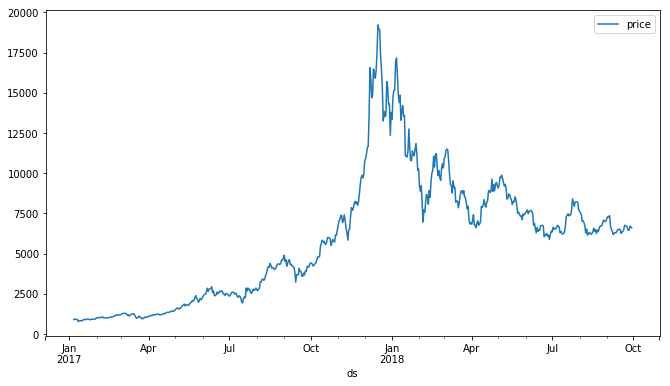

In [16]:
df.plot(x='ds', y ='price')

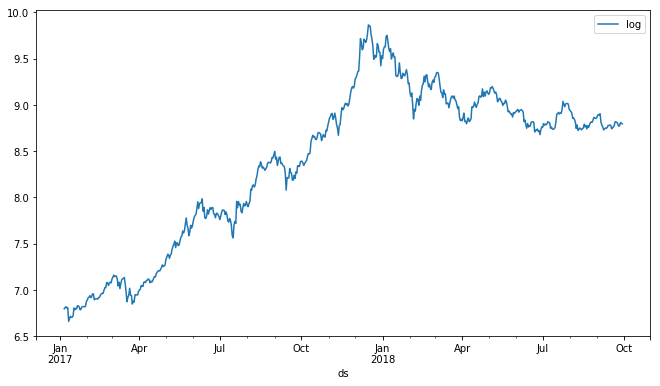

In [17]:
df.plot(x='ds', y ='log')

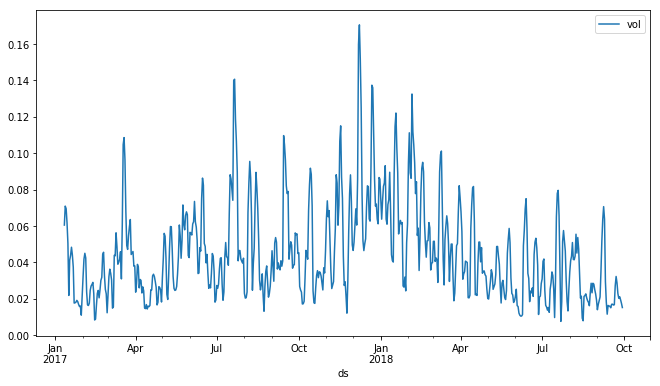

In [18]:
df.plot(x='ds', y ='vol')

Shows the trends and daily differences for 5 different weeks

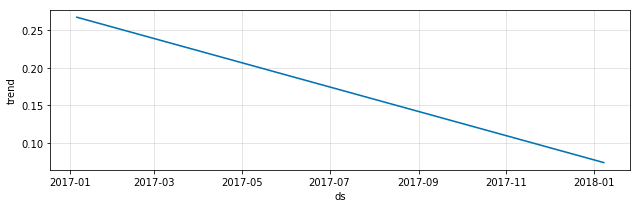

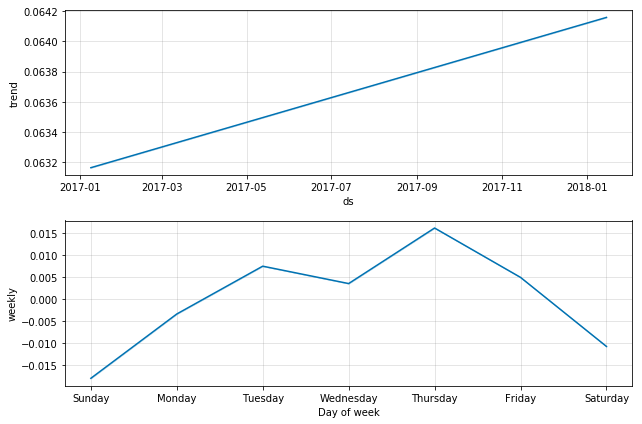

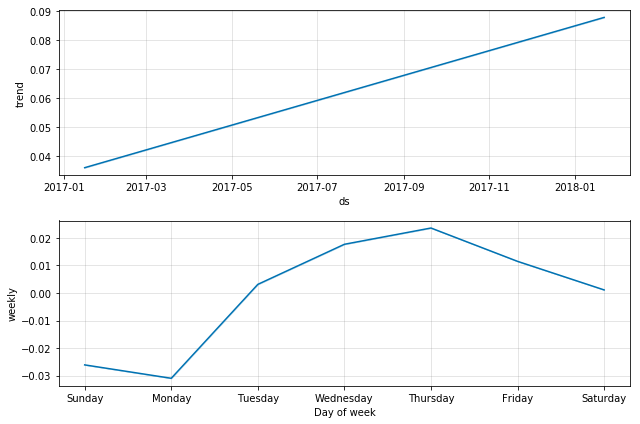

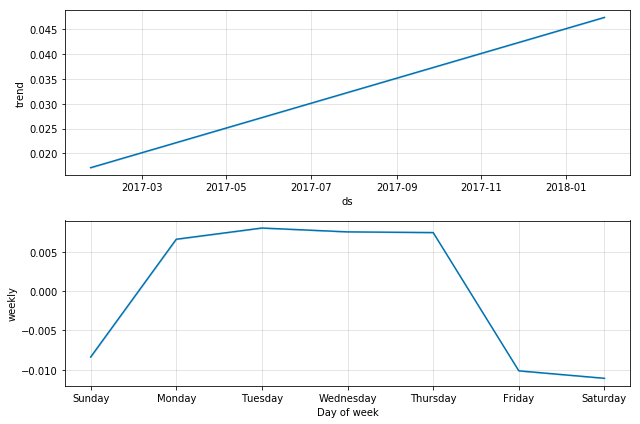

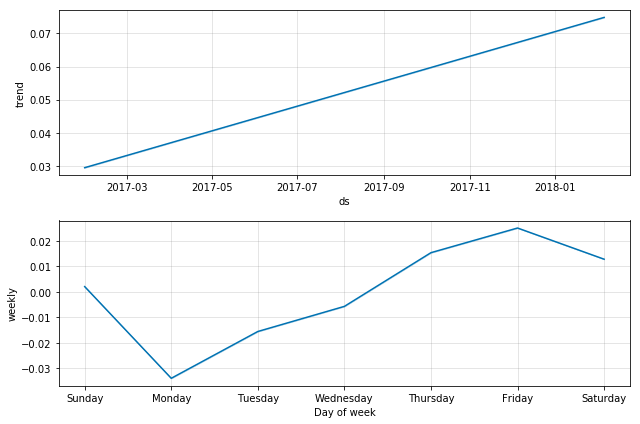

In [19]:
d = dict(tuple(df.groupby(df['ds'].dt.week)))
for i, df_week in d.items()[:5]:
    m = Prophet()
    m.fit(df_week)
    future = m.make_future_dataframe(periods=1)
    future.tail()
    forecast = m.predict(future)
    fig2 = m.plot_components(forecast)

Generates the velocity and acceleration of the volatility

In [20]:
def fitKCA(t,z,q,fwd=0):
    '''
    Inputs:
    t: Iterable with time indices
    z: Iterable with measurements
    q: Scalar that multiplies the seed states covariance
    fwd: number of steps to forecast (optional, default=0)
    Output:
    x[0]: smoothed state means of position velocity and acceleration
    x[1]: smoothed state covar of position velocity and acceleration
    Dependencies: numpy, pykalman
    '''
    #1) Set up matrices A,H and a seed for Q
    h=(t[-1]-t[0])/t.shape[0]
    A=np.array([[1,h,.5*(h*h)],
            [0,1,h],
            [0,0,1]])
    Q=q*np.eye(A.shape[0])
    #2) Apply the filter
    kf=KalmanFilter(transition_matrices=A,transition_covariance=Q)
    #3) EM estimates
    kf=kf.em(z)
    #4) Smooth
    x_mean,x_covar=kf.smooth(z)
    #5) Forecast
    for fwd_ in range(fwd):
        x_mean_,x_covar_=kf.filter_update(filtered_state_mean=x_mean[-1],filtered_state_covariance=x_covar[-1])
        x_mean=np.append(x_mean,x_mean_.reshape(1,-1),axis=0)
        x_covar_=np.expand_dims(x_covar_,axis=0)
        x_covar=np.append(x_covar,x_covar_,axis=0)
    #6) Std series
    x_std=(x_covar[:,0,0]**.5).reshape(-1,1)
    for i in range(1,x_covar.shape[1]):
        x_std_=x_covar[:,i,i]**.5
        x_std=np.append(x_std,x_std_.reshape(-1,1),axis=1)
    return x_mean,x_std,x_covar

In [21]:
# by MLdP on 02/20/2014 <lopezdeprado@lbl.gov>
# Kinetic Component Analysis of a periodic function
import matplotlib.pyplot as pp
mainPath=''
#---------------------------------------------------------
def vsFFT(t,z):
    #3) Fit KCA
    x_point,x_bands=fitKCA(t,z,q=.001)[:2]
    #4) Plot KCA's point estimates
    color=['b','g','r']
    pp.plot(t,z,marker='x',linestyle='',label='measurements')
    pp.plot(t,x_point[:,0],marker='o',linestyle='-',label='position', color=color[0])
    pp.plot(t,x_point[:,1],marker='o',linestyle='-',label='velocity', color=color[1])
    pp.plot(t,x_point[:,2],marker='o',linestyle='-',label='acceleration', color=color[2])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    #5) Plot KCA's confidence intervals (2 std)
    for i in range(x_bands.shape[1]):
        pp.plot(t,x_point[:,i]-2*x_bands[:,i],linestyle='-',color=color[i])
        pp.plot(t,x_point[:,i]+2*x_bands[:,i],linestyle='-',color=color[i])
    pp.legend(loc='lower left',prop={'size':8})
    pp.show()
    pp.clf();pp.close() # reset pylab
    return

In [22]:
mainPath=''
#---------------------------------------------------------
def v_a(df):
    result = fitKCA(df['date'].values, df['y'].values, 0.01, 0)
    x_mean,x_std,x_covar=fitKCA(df.date.values, df.y.values, .1) 
    
    df['velocity'] = x_mean[:,1]
    df['acceleration'] = x_mean[:,2]
    print(df['velocity'].describe())
    print(df['acceleration'].describe())
    
    vsFFT(df['date'].values, df['y'].values)
    
    p_df = df[['ds', 'velocity', 'acceleration']].copy()

    p_df['y'] = p_df['velocity']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

    p_df['y'] = p_df['acceleration']
    m = Prophet(seasonality_mode='multiplicative')
    m.fit(p_df)
    future = m.make_future_dataframe(periods=14)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)

In [23]:
df = df.dropna()

In [24]:
def gen_v_a(df):
    result = fitKCA(df['date'].values, df['vol'].values, 0.01, 0)

    df['v'] = result[0][:,1]
    df['a'] = result[0][:,2]

In [25]:
gen_v_a(df)

Shows the std, mean of v and a

In [26]:
df.describe()

,date,price,log,vol,y,v,a
count,6.270000e+02,627.000000,627.000000,627.000000,627.000000,6.270000e+02,6.270000e+02
mean,1.511136e+09,5903.079644,8.397605,0.045365,0.045365,-1.553984e-10,-9.350427e-15
std,1.565081e+07,3930.836672,0.831664,0.026352,0.026352,1.788149e-07,2.251962e-12
min,1.484093e+09,781.811601,6.661614,0.007521,0.007521,-6.096767e-07,-1.013910e-11
25%,1.497614e+09,2415.830694,7.789793,0.025132,0.025132,-9.964856e-08,-1.182688e-12
50%,1.511136e+09,6265.659916,8.742839,0.040285,0.040285,-2.672828e-09,-1.585995e-14
75%,1.524658e+09,8170.522506,9.008288,0.059550,0.059550,8.896213e-08,1.169981e-12
max,1.538179e+09,19223.000000,9.863863,0.170529,0.170529,8.411749e-07,9.231004e-12


Creates a data frame of the rolling means of df for x,v, and a

In [27]:
def gen_rolling(df):
    rolling = pd.DataFrame()
    rolling['ds'] = df['ds']
    for item in ['vol','v','a']:
        rolling[item] = df[[item]].rolling(10).mean()
        rolling[item+"std"] = rolling[[item]].rolling(10).std()
        rolling[item+"std"] = [float(i) for i in rolling[item+"std"]]
    return rolling

In [28]:
rolling = gen_rolling(df)

Plots the data versus the 10 day rolling mean of each value

In [29]:
def plot_raw(df, rolling):
    vals = df.plot(x='ds', y =['vol','v','a'], style='.', legend=False, color=colors);
    rolling.plot(x='ds', y =['vol','v','a'], ax=vals, legend=True, color=colors)

Plots the data with a 95% confidence interval overlay

In [30]:
def plot_uncertain(df, rolling):
    vals = df.plot(x='ds', y =['vol','v','a'], style='.', legend=False, color=colors)
    rolling.plot(x='ds', y=['vol','v','a'], yerr=2*rolling[['volstd','vstd','astd']], ax=vals, legend=True, color=colors)

Plots the three axis method

In [31]:
def plot_overlayed_kca(df):
    x_mean,x_std,x_covar=fitKCA(df['date'].values,df['y'].values,1)
    np.random.seed(2009)
    #Shoutout Satoshi

    #fig, ax = plt.subplots()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax3 = ax1.twinx()
    fig.subplots_adjust(right=0.75)
    ax3.spines['right'].set_position(('axes', 1.1))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)

    #position
    ax1.set_ylabel('position',color='b')
    ax1.plot(x_mean[:,0],color='b')
    #velocity
    ax2.set_ylabel('velocity',color='g')
    ax2.plot(x_mean[:,1],color='g')
    #acceleration
    ax3.set_ylabel('acceleration',color='r')
    ax3.plot(x_mean[:,2],color='r')

    fig.tight_layout()
    plt.show()

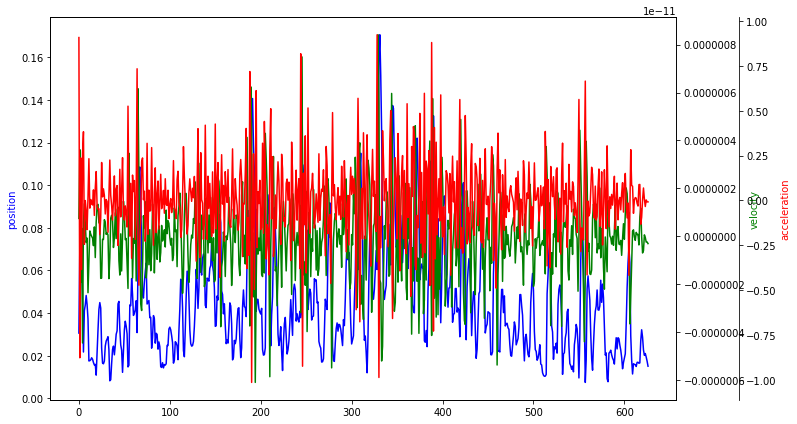

In [32]:
plot_overlayed_kca(df)

Creates prophet for only KCA values

In [33]:
def gen_kca(df):
    m = Prophet(seasonality_mode='multiplicative')
    kca = pd.DataFrame()
    kca['ds'], kca['v'], kca['a'] = df['ds'],df['v'],df['a']
    kca['y'] = kca['v']
    m.fit(kca)
    return m

In [34]:
m = gen_kca(df)

Plots KCA results

In [35]:
def plot_m_future(p):
    future = m.make_future_dataframe(periods=p)
    future.tail()
    forecast = m.predict(future)
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
    fig1 = m.plot(forecast)
    a = add_changepoints_to_plot(fig1.gca(), m, forecast)
    fig2 = m.plot_components(forecast,uncertainty=True)

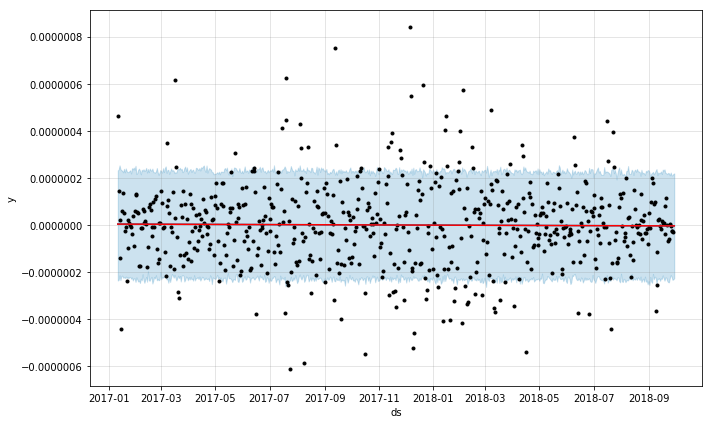

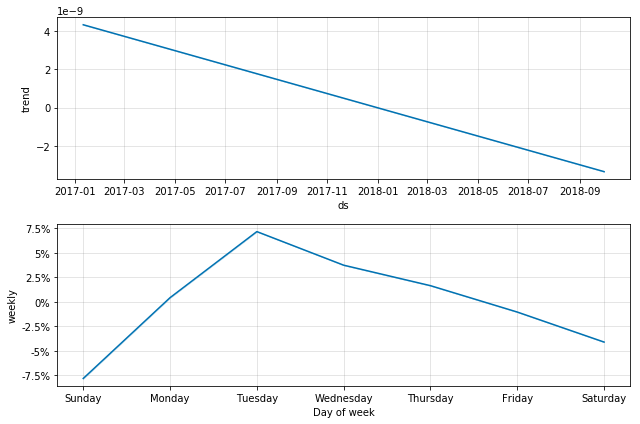

In [36]:
plot_m_future(1)

Runs the above on 6 months

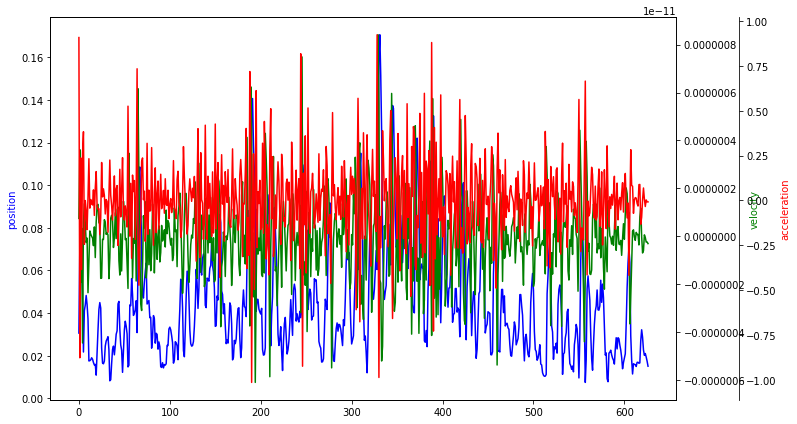

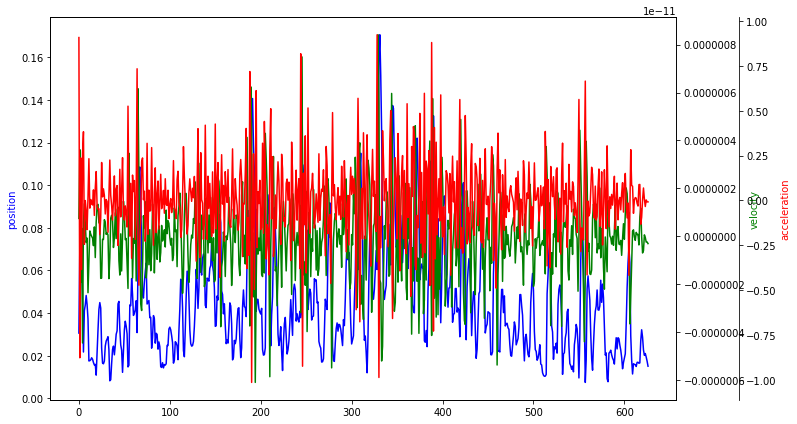

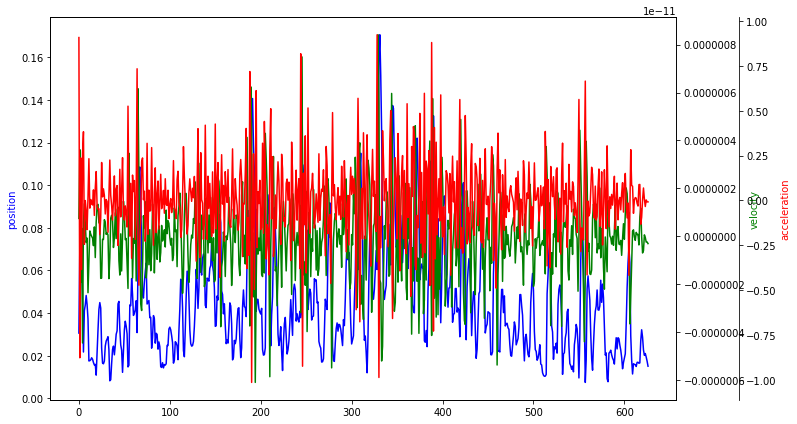

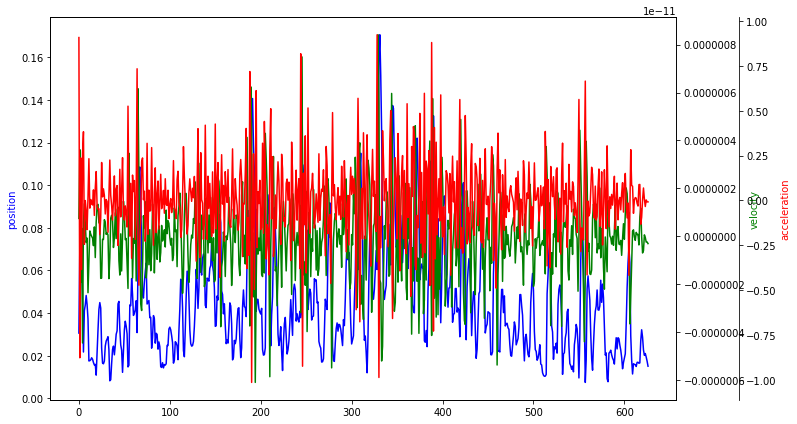

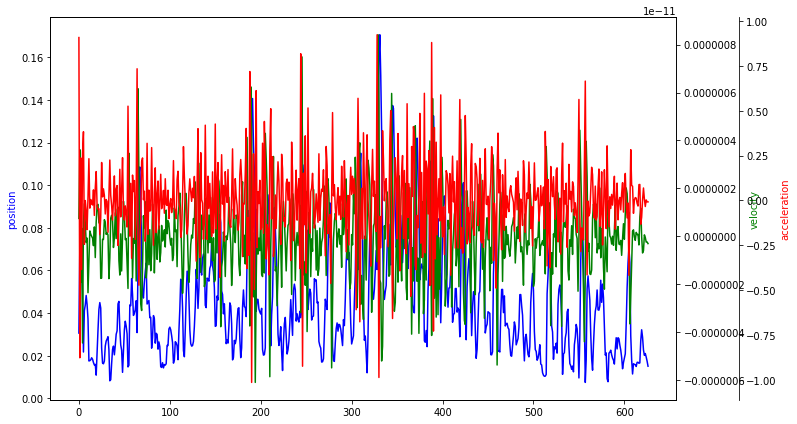

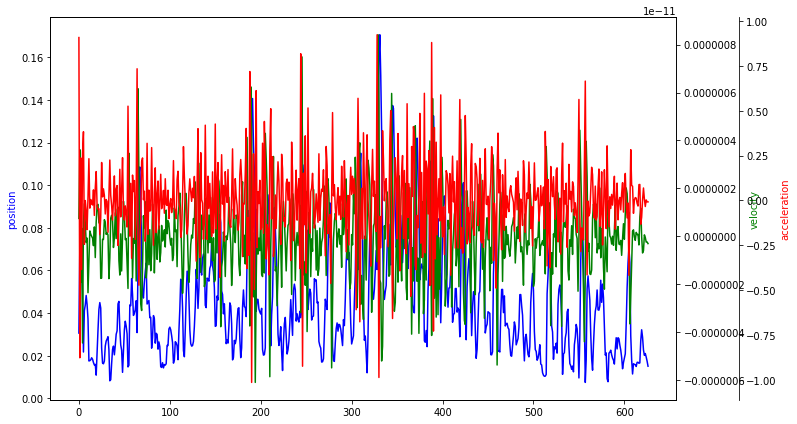

In [37]:
d = OrderedDict(tuple(df.groupby((df.ds.dt.year, df.ds.dt.month))))
for i, df_month in d.items()[:6]:
    gen_v_a(df_month)
#     rolling = gen_rolling(df_month)
    plot_overlayed_kca(df)
#     plot_raw(df_month, rolling)
#     plot_uncertain(df_month, rolling)
#     m = gen_kca(df_month)
#     plot_m_future(5)

Runs the above on 3 bi-monthlys

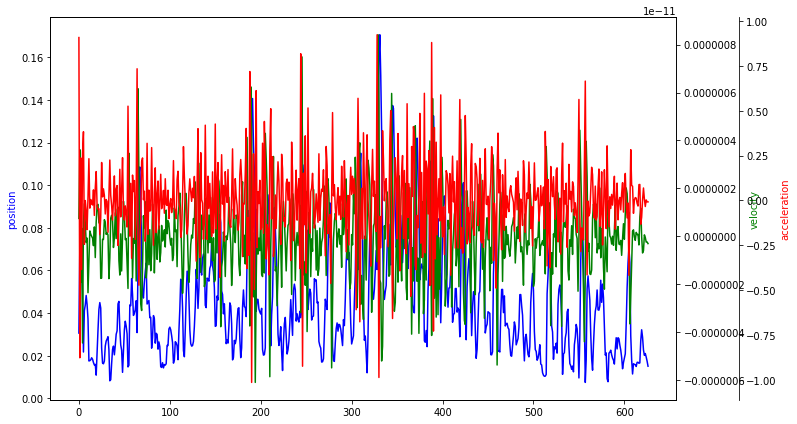

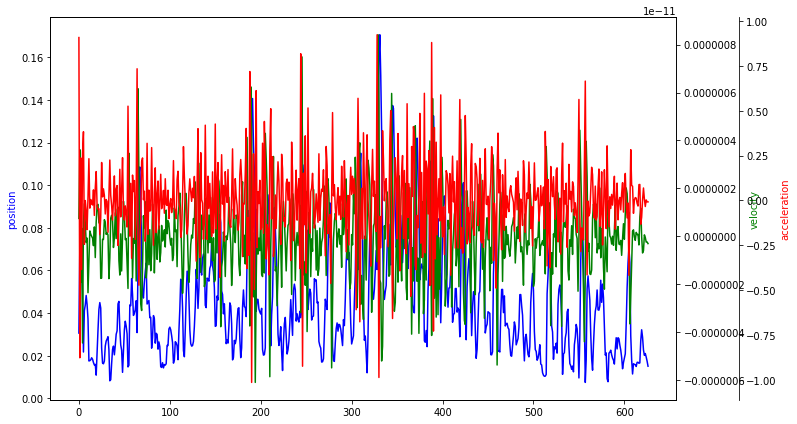

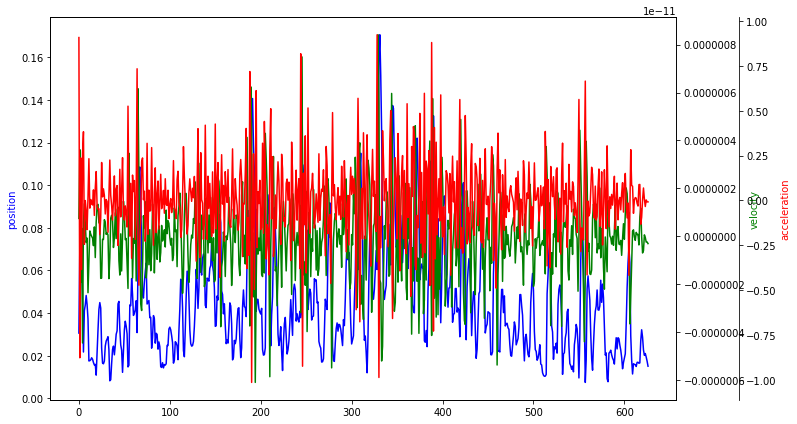

In [38]:
second = False
current_df = None
for i, df_month in d.items()[:6]:
        if second:
            second = False
            df_bimonth = pd.concat([current_df,df_month])
            gen_v_a(df_bimonth)
#             rolling = gen_rolling(df_bimonth)
            plot_overlayed_kca(df)
#             plot_raw(df_bimonth, rolling)
#             plot_uncertain(df_bimonth, rolling)
#             m = gen_kca(df_bimonth)
#             plot_m_future(5)
        else:
            second = True
            current_df = df_month

Runs the above on 2 quarters

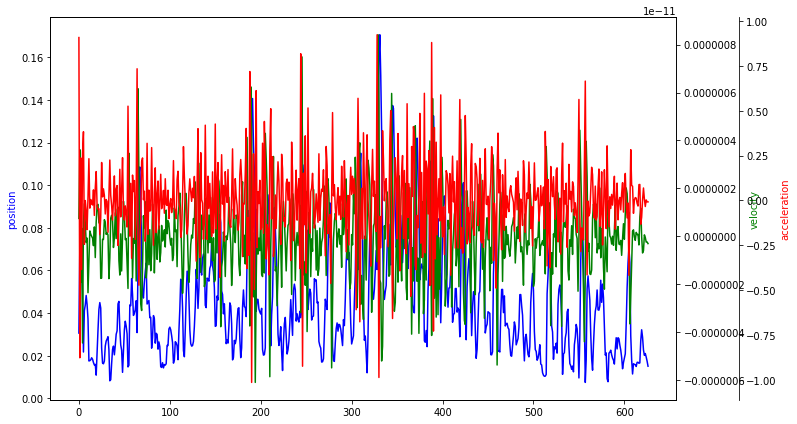

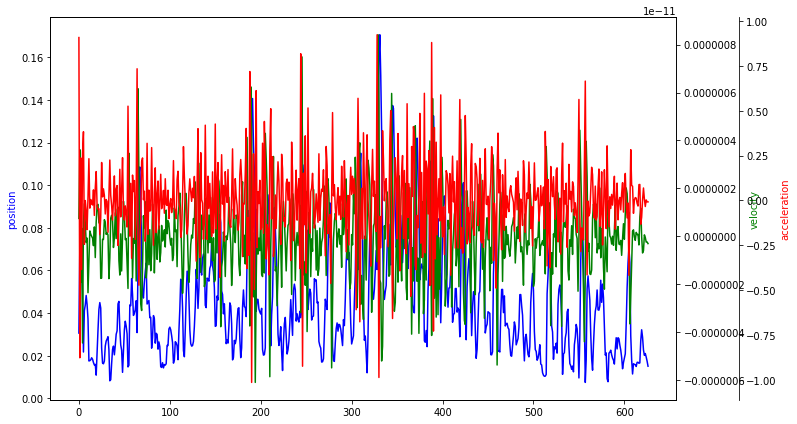

In [39]:
loop_c = 0
current_dfs = []
for i, df_month in d.items()[:6]:
        if loop_c == 2:
            df_bimonth = pd.concat([current_dfs[0], current_dfs[1], df_month])
            loop_c = 0
            current_dfs = []
            gen_v_a(df_bimonth)
#             rolling = gen_rolling(df_bimonth)
            plot_overlayed_kca(df)
#             plot_raw(df_bimonth, rolling)
#             plot_uncertain(df_bimonth, rolling)
#             m = gen_kca(df_bimonth)
#             plot_m_future(5)
        else:
            loop_c += 1
            current_dfs.append(df_month)